In [1]:

#check what version of python you're using - I'm using 3.7.3
from platform import python_version
print(python_version())


# In[3]:

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys


import matplotlib.pyplot as plt
def implot(data, w, wcscond, vmax_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=vmax_p)
    plt.xlabel('RA')
    plt.ylabel('Dec')

3.7.3


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])

    #saving the file
    new_filename = name.split('/')[-1]  #grabs the file name we were using from before
    hdul.writeto(save_path+new_filename, overwrite=True)

    return (save_path+new_filename)



In [3]:

# In[21]:
#declaring noise: measured from the RMS of a region of empty sky while opening the image in DS9
#these are newly taken from the HH 6 images...
# noise_126 = 0.0465246
# noise_128 = 0.04733
# noise_164 = 0.0561296

#from the regridded images...
noise_126 = 0.216037
noise_128 = 0.258513
noise_164 = 0.39321
noise_halpha = 0.302712
#converting units for reference
#hdu1_conv_scaled = hdu1_conv_scaled * hdu1_fnu / 1e6 #converting to MJy
#hdu1_conv_scaled = hdu1_conv_scaled / hdu1_pix**2. * 4.25e10 #dividing out sr, D001SCAL is key for pixel size in arcsec



#EX: grabbing all the fits image paths in a directory, so they can be looped through and their data opened
#set your path to some directory with images (the images can be in subdirectories)
#using ** will grab all files even in subdirectories...WARNING this will take longer
path = '../../../ngc1333_fits/'
im_names_hub_dash = im_name_finder(path+'*', 'fit')
im_names_hub_dash = [i.replace('\\', '/') for i in im_names_hub_dash]
im_names_hub = [path+'126_image.fits', path+'128_image.fits', path+'164_image.fits', path+'halph_hart_image.fits']


# In[28]:

#Minimal loop through all the images, including a try/except in case an image is faulty for whatever reason
#IMPORTANT: A more detailed example between two single images is at the end of this code with many more comments

#First, we need to setup the image we're projecting ONTO
#This will be the same no matter the loop, so only need to do this once
#low_res = [x for x in im_names_spitz if 'n1333_lh_3_SiII_' in x][0]  #finding the lowest res image - LH and long lambda, so [SiII]
#hdu1 = fits.open(low_res)[0]

low_res = im_names_hub_dash[2]   #Could also let this be a hubble image...if so, see the hubble loop below for how to setup grabbing the data, header, pixel conversion from the hdu
hdu2 = fits.open(low_res)

#reading in data
hdu2_pix = hdu2[0].header['D001SCAL'] #same as above line, but D001SCAL is the keyword for Hubble images
hdu2_pix_torad = hdu2_pix / 206265
hdu2_fnu = hdu2[0].header['PHOTFNU']
hdu2_bw = hdu2[0].header['PHOTBW']


#now working with long exposure image (necessary for working with data based on header)
low_res = im_names_hub[1]
name = low_res
hdu2 = fits.open(name)
hdu2_data = hdu2[0].data
hdu2_header = hdu2[0].header

#converting noise units
noise_128 = noise_128 * hdu2_fnu / 1e6


[1.551201963787455e-12, 2.1282158927278465e-13]
0.17740340702567514 0.05689484714229737 2.7518851336081245e-13


SystemExit: 

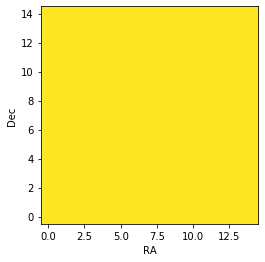

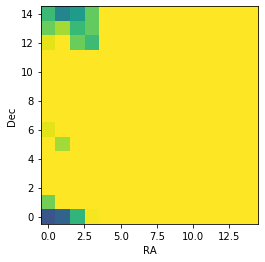

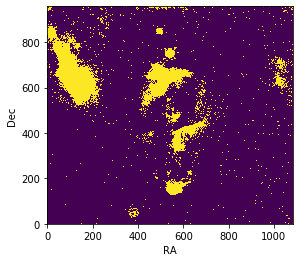

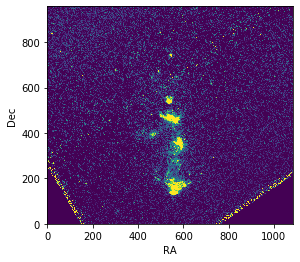

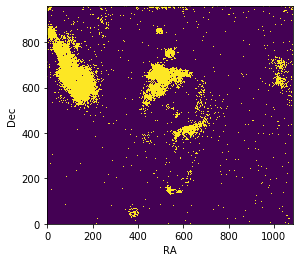

In [87]:
for name2 in [im_names_hub[3]]:

    #need to do halpha image as well...
    hdu3 = fits.open(im_names_hub_dash[6])

    #reading in data
    hdu3_pix = hdu3[0].header['D001SCAL'] #same as above line, but D001SCAL is the keyword for Hubble images
    hdu3_pix_torad = hdu3_pix / 206265

    #under science header of the original image
    hdu3_fnu = hdu3[1].header['PHOTFNU']
    hdu3_bw = hdu3[1].header['PHOTBW']
    
    #opening the regridded image?
    hdu3 = fits.open(name2)
    hdu3_data = hdu3[0].data
    hdu3_header = hdu3[0].header
    
    #converting noise units
    noise_halpha = noise_halpha * hdu3_fnu / 1e6



    #reprojection of one hdu using the header (coords and pixels) of another
    #The first input is the path to the file we're reprojecting. The second input is the header of the image we're projecting ONTO
    #you'll need to set the WCS to be that of the header you're basing this off of...ie the header

    #file_start = 'Convolved_Images_Hub/conv_'
    #conv2_path = file_start + name.split('/')[-1]

#     w = WCS(hdu1_header)
#     wcs_header = w.to_header()
    file_start = '../../Convolved_Images_Hub/conv_'
#     hdu1_conv = fits.open(file_start + low_res.split('/')[-1])
#     hdu1_conv_scaled = hdu1_conv[0].data * hdu1_pix**2. / 4.25e10

     #para is False for large images (like these hubble ones)
    #output is array (a 2D array of data) and footprint (the footprint from the analysis)
    file_start = '../../Regridded_Hub/regrid_'
    hdu_regrid_hub = fits.open(file_start + name.split('/')[-1])
    array = hdu_regrid_hub[0].data * hdu2_pix**2. / 4.25e10   
    
    
    #
    hdu_regrid_hub2 = fits.open(file_start + name2.split('/')[-1])
    array2 = hdu_regrid_hub2[0].data * hdu3_pix**2. / 4.25e10
    


    #now that we have a reprojected hubble image for hdu2 and both are convolved, need to
    #divide one by the other...then can use the same wcs header that we projected onto (hdu1's)!
    #getting rid of nan values
    where_are_NaNs = np.isnan(array)
    array[where_are_NaNs] = 0.

    where_are_NaNs = np.isnan(array2)
    array2[where_are_NaNs] = 0.

#     where_are_NaNs = np.isnan(hdu1_conv_scaled)
#     hdu1_conv_scaled[where_are_NaNs] = 0.

    #print(perc * np.max(array))
    #array[array < (perc * np.max(array))] = 0.  #only taking values greater than some percent of the maximum


    #scaling by the signal to noise
    perc = 0.2 #this tends to work?? Maybe can change...
    perc2 = 0.2
    
    array[array < noise_128*perc] = 0.
    array2[array2 < noise_halpha*perc2] = 0.
#     hdu1_conv_scaled[hdu1_conv_scaled < noise_126*perc] = 0.

    #getting rid of 0 values
    array[array < 0.] = 0.
    array2[array2 < 0.] = 0.
#     hdu1_conv_scaled[hdu1_conv_scaled < 0.] = 0.

    
   
    #cutting out part of the image...HH 10 or HH 7 in order to make scattered light image
    #purpose is to find max of the region to use to normalize the image
    count = 0
    hh10_max = []
    coords = [(560, 460), (13, 13)] #these coordinates worked before...hopefully works again?
    coords = [(550, 137), (15, 15)] #hh7, 556,135 and 8, 25
#     coords = [(535, 546), (10, 10)] #hh11
    
    #finding max or mean value from a region
    for tups in [(array, hdu2_header), (array2, hdu3_header)]:
        #unpacking coords and data
        position = coords[0]
        size = coords[1]
        data = tups[0]
        w = WCS(tups[1])

        #cutting out coordinates
        cutout = Cutout2D(data, position, size, wcs = w)
        datacut = cutout.data
        wcscut = cutout.wcs

        #plotting image
        implot(datacut, wcscut, False, 1e-13) 
        
        #defining max value in region of hh7-11
        hh10_max.append(np.mean(datacut))
        count += 1
#     sys.exit()

#     eps = 8e-1 
#     epslist = [1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 7e-1, 8e-1, 9e-1, 99e-1]
#     epslist = [0.0]
    
#     for eps in epslist:
    flux01 = array / hh10_max[0] #*1e6*1e-23*hdu2_bw #normalizing to max and converting units to lam*flam #hdu1_conv_scaled - eps * array
    flux02 = array2 / hh10_max[1] #*1e6*1e-23*hdu3_bw #normalizing to max and converting units to nu*fnu
    data_subtrac = flux01 - flux02
#     data_ratio = np.divide(flux01, flux02, out=np.zeros_like(flux02), where=flux02!=0.) #need to do np.divide to guarantee we get no divide by zero issue...


    #plotting image to check
    print(hh10_max)
    print(np.mean(flux01), np.mean(flux02), np.mean(array))
    implot(array, w, False, 1e-13) 
    implot(array2, w, False, 1e-13) 
    implot(data_subtrac, w, False, 1e-3) 


    # remember to have the right header with the wcs below and that it matches the one we're projecting ONTO
    w = WCS(hdu2_header)
    wcs_header = w.to_header()
    save_path = './'  #See fits_saver's "save_path" description for explanation
    fits_saver(data_subtrac, wcs_header, 'hub_noleakage_imscatt__ston_'+str(perc)+'.fits', save_path)  #saving the reprojected image

sys.exit()

